<a href="https://colab.research.google.com/github/devika-kla/Machine-learning-tasks/blob/XAI/GradCAM_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

In [ ]:
import cv2
import numpy as np

img_bgr = cv2.imread('/content/n01443537_goldfish.JPEG') #source: https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01443537_goldfish.JPEG?raw=true://unsplash.com/photos/nKC772R_qog
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_resized = cv2.resize(img_rgb, (224, 224), interpolation = cv2.INTER_CUBIC)

img_tensor = np.expand_dims(img_resized, axis=0) #add batch axis, shape (1,224,224,3)
img_tensor = tf.keras.applications.vgg16.preprocess_input(img_tensor)


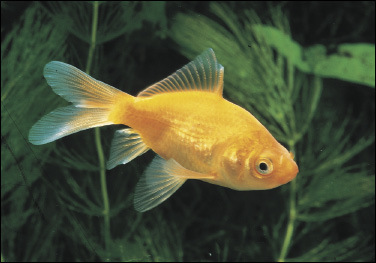

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img_bgr)

In [ ]:
predictions = vgg16_model.predict(img_tensor)
print(tf.keras.applications.vgg16.decode_predictions(predictions)[0])

35363/35363 [==============================] - 0s 0us/step
[('n01443537', 'goldfish', 0.99951184), ('n01440764', 'tench', 0.00038880217), ('n01632777', 'axolotl', 8.857987e-05), ('n02606052', 'rock_beauty', 6.812383e-06), ('n02655020', 'puffer', 3.6548588e-06)]


In [ ]:
last_conv_layer = vgg16_model.get_layer('block5_conv3') #Output feature map of last convolutional layer in VGG16

heatmap_model = tf.keras.models.Model(inputs=vgg16_model.input,
                                      outputs=[last_conv_layer.output, vgg16_model.output])

with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2)) #Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat


Text(0.5, 1.0, 'Applied Grad-CAM')

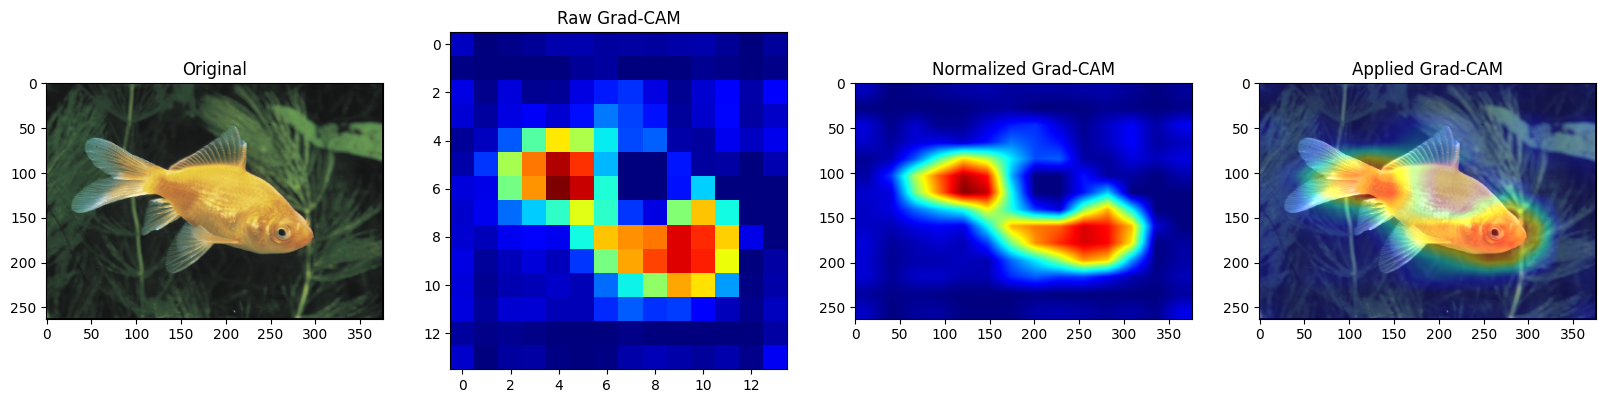

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

squeezed_hm = np.squeeze(heatmap)
normalized_hm = cv2.resize(squeezed_hm, (img_bgr.shape[1], img_bgr.shape[0]))
normalized_hm = (255 * normalized_hm).astype(np.uint8)
normalized_hm = cv2.applyColorMap(normalized_hm, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(normalized_hm, 0.4, img_bgr, 0.9, 0)

rows, cols = 1, 4
fig,axs = plt.subplots(rows, cols, figsize=(20, 20))

axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')

axs[1].imshow(squeezed_hm, cmap='jet')
axs[1].set_title('Raw Grad-CAM')

axs[2].imshow(cv2.cvtColor(normalized_hm, cv2.COLOR_BGR2RGB))
axs[2].set_title('Normalized Grad-CAM')

axs[3].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axs[3].set_title('Applied Grad-CAM')
